# Установка и импорт библиотек

In [ ]:
!pip3 install langgraph
!pip3 install -U langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 7.8 MB/s eta 0:00:00


In [ ]:
from typing import TypedDict, List, Annotated, Literal
from langgraph.graph.message import add_messages
from pandas.api.types import is_numeric_dtype

from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from pydantic import BaseModel, Field

import pandas as pd
import json

# Инициализация llm

In [ ]:
llm = ChatGroq(
    model='llama-3.3-70b-versatile'
    , temperature=0.1
    , api_key=''
)

# Логика графа

In [ ]:
class UserState(TypedDict):
    # Инициализируется сразу
    messages: Annotated[list, add_messages] # - сообщение, с которой пришел пользователь
    data: pd.DataFrame                      # - датасет

    target: str                             # - переменной по которой будем делать стат тесты
    grouping_variable: str                  # - все переменные которые пойдут в логику исследования
    grouping_values: List[str]              # - разделюящие группирующую переменную на выборки
    satisfied: str                          # - состояние выбронных переменных
    is_normal_target: bool                  # - нормальное ли распределение таргета

    samples: List[str]                      # - группы для стат теста

    target_dtype: str                       # - тип целевой переменной
    grouping_variable_dtype: str            # - тип группирующей переменной

    method_of_var_analisis: str             # - метод дисперсионного анализа**

    artefacts: List[str]                    # - все что будет переданно в llm для вывода сводки

    summary: str                            # - сводка исследования

## Определение переменных исследования

In [ ]:
class TargetExtraction(BaseModel):
    target: str = Field(description='Название зависимой переменной. По которой будет производиться стат тест. Тип может быть любой.')
    grouping_variable: str = Field(description='Группирующая переменная. Если подразумеватеся проверка нескольких групп, рекомендуется использовать одну переменную. Тип может быть любой.')
    grouping_values: List[str] = Field(description='Значения, разделюящие группирующую переменную на выборки (в том числе и какие-то значение числовой переменной, НО передавать строго списком, из str значений). Также тут можем быть СПИСОК с одним значением "ALL", если к примеру, необходимо провести анализ взаимосвязи двх количественных переменных.')

def find_variables(state: UserState) -> UserState:
    data = state['data']
    all_counts = {}
    for col in data.columns:
        counts = data[col].value_counts().head(10).to_dict()
        if len(data[col].unique()) > 10:
            counts['...'] = f'and {len(data[col].unique()) - 10} more'

        all_counts[col] = counts
    sys_prompt = f'Ты помощник аналитика. По сообщению пользователя, тебе необходимо определить значения зависимой переменной и группирующей. Исходи из того, что хочет пользователь.'\
                f'Вот данные, пользователя. dtypes: {data.dtypes.to_string()}\nvalues counts: {json.dumps(all_counts, ensure_ascii=False, indent=2)}'

    messages = state['messages']
    instruction = HumanMessage(content='Внимательно изучи последние системные сообщения об ошибках и исправь свой выбор переменных согласно им. Не повторяй предыдущие ошибки.')
    structured_llm = llm.with_structured_output(TargetExtraction)

    result = structured_llm.invoke([sys_prompt] + messages + [instruction])

    return {
        'target': result.target
        , 'grouping_variable': result.grouping_variable
        , 'grouping_values': result.grouping_values
    }

In [ ]:
class CorrectingVariables(BaseModel):
    answer: Literal['YES', 'NO'] = Field(description='Выбор удовлетворил пользователя? Толко YES или NO')
    correction_message: str = Field(description='Опиши переменные которые пользователь хочет поменять и на что, а какие хочет оставить. Если пользователя все устроило, оставь пробел.')

def is_correct_variables(state: UserState) -> UserState:
    print(f'Выбран таргет: {state['target']}, групповая переменная: {state['grouping_variable']}, ее значения: {' '.join(state['grouping_values'])}')
    response = input('Вас удовлетворяет выбор? ')
    structured_llm = llm.with_structured_output(CorrectingVariables)
    analysis = structured_llm.invoke(
        f'Пользователь ответил на выбор переменных. \n'
        f'Выбрано: target={state['target']}, group={state['grouping_variable']}. \n'
        f'Ответ пользователя: {response}'
    )
    new_messages = state.get('messages', [])
    if analysis.answer == 'NO':
        feedback_msg = SystemMessage(content=f"ОШИБКА: Пользователь недоволен. Исправь выбор. {analysis.correction_message}")
        new_messages.append(feedback_msg)
    return {
        'satisfied': analysis.answer,
        'messages': new_messages
    }

## другие функции

In [ ]:
class CorrectingDtype(BaseModel):
    target_dtype: Literal['string', 'int64', 'float64', 'bool'] = Field(
        description='Тип данных pandas. Если значений всего 2 — строго string.'
    )
    grouping_variable_dtype: Literal['string', 'int64', 'float64', 'bool'] = Field(
        description='Тип данных pandas. Для ID и категорий — строго string.'
    )

def correct_dtypes(state: UserState) -> UserState:
    data = state['data']
    data = data[[state['target'], state['grouping_variable']]]

    all_counts = {}
    for col in data.columns:
        counts = data[col].value_counts().head(10).to_dict()
        if len(data[col].unique()) > 10:
            counts['...'] = f'and {len(data[col].unique()) - 10} more'
        all_counts[col] = counts

    conditions = (
        '1. БИНАРНАЯ ПЕРЕМЕННАЯ (например, 0 и 1) — это всегда string. ЗАПРЕЩЕНО выбирать int.\n'
        '2. ID, Дата, Категории — всегда string.\n'
        '3. Непрерывные переменные — float64.\n'
        '4. Остальное — исходя из здравого смысла.'
    )

    prompt = (
        f'Твоя задача определить КОРРЕКТНЫЙ тип данных.\n'
        f'ПРАВИЛО: Если видишь 0 и 1 или два уникальных значения — используй string!\n'
        f'СХЕМА: {conditions}\n'
        f'ДАННЫЕ: {data.dtypes.to_string()}\n'
        f'VALUE COUNTS: {json.dumps(all_counts, ensure_ascii=False)}'
    )

    structured_llm = llm.with_structured_output(CorrectingDtype)
    result = structured_llm.invoke(prompt)

    return {
        'target_dtype': result.target_dtype,
        'grouping_variable_dtype': result.grouping_variable_dtype,
        'data': data
    }

In [ ]:
def correcting_dtypes(state: UserState) -> UserState:
    data = state['data'].copy()
    target = state['target']
    grouping_variable = state['grouping_variable']
    old_dtypes = data[[target, grouping_variable]].dtypes
    try:
        data[target] = data[target].astype(state['target_dtype'])
        data[grouping_variable] = data[grouping_variable].astype(state['grouping_variable_dtype'])
    except Exception as e:
        print(f'Ошибка смены типа: {e}')

    new_dtypes = data[[target, grouping_variable]].dtypes

    if old_dtypes.to_string() != new_dtypes.to_string():
        artefact = (
            f'Изменены типы данных:\n'
            f'БЫЛО:\n{old_dtypes.to_string()}\n'
            f'СТАЛО:\n{new_dtypes.to_string()}'
        )
    else:
        artefact = 'Типы данных остались прежними.'

    return {
        'data': data,
        'artefacts': state.get('artefacts', []) + [artefact]
    }


In [ ]:
def cleaning_target(state: UserState) -> UserState:
    data = state['data'].copy()
    target = state['target']
    grouping_variable = state['grouping_variable']

    lower_bound = None
    upper_bound = None

    if data[grouping_variable].dtype in ['float64', 'int64']:
        q1 = data[grouping_variable].quantile(0.25)
        q3 = data[grouping_variable].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        data = data[(data[grouping_variable] >= lower_bound) & (data[grouping_variable] <= upper_bound)]

    if lower_bound is not None:
        count_removed = len(state['data']) - len(data)
        artefact = f'Были очищены выбросы: {count_removed}. Границы: {lower_bound:.2f} - {upper_bound:.2f}'
    else:
        artefact = f'Переменная {grouping_variable} не является числовой, очистка выбросов пропущена.'

    return {
        'data': data,
        'artefacts': state.get('artefacts', []) + [artefact]
    }


# Узел перехода к стат тестам

In [ ]:
def identifying_variables(state: UserState) -> UserState:
    # target & grouping_variable
    data = state['data']
    groups = state['grouping_values']

    target = state['target']
    grouping_variable = state['grouping_variable']

    len_of_groups = len(groups)
    if len_of_groups == 1 or len_of_groups == 2:
        if is_numeric_dtype(data[target]) and is_numeric_dtype(data[grouping_variable]):
            if groups[0] == 'ALL':
                return 'ALL_NUMERIC' # две количественные
            else:
                return 'ONE_NUMERIC_AND_ONE_NOMINATIV' # одна номинативная друга количественная
        elif not is_numeric_dtype(data[target]) and not is_numeric_dtype(data[grouping_variable]):
            return 'ALL_NOMINATIV' # обе номинативные
        elif is_numeric_dtype(data[target]) and not is_numeric_dtype(data[grouping_variable]):
            return 'ONE_NUMERIC_AND_ONE_NOMINATIV' # одна номинативная друга количественная
    else:
        if is_numeric_dtype(data[target]):
            return 'MANY_GROUPS_AND_NUMERIC_TARGET' # таргет количественный
        elif not is_numeric_dtype(data[target]):
            return 'MANY_GROUPS_AND_NOMINATIV_TARGET' # таргет номинативный

# Обе переменные количественные

In [ ]:
# identifying_variables -> ALL_NUMERIC
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def make_lin_reg(state: UserState) -> UserState:
    data = state['data']
    x = sm.add_constant(data[state['grouping_variable']])
    y = data[state['target']]
    model = sm.OLS(y, x).fit()
    artefact = f'По скольку в выбранных переменных обе переменные количественные, построим линейную регрессию. Сводка (summary):\n{str(model.summary())}'
    print('Уже строю линейную регрессию!')
    return {'artefacts': state.get('artefacts', []) + [artefact]}

def make_corrs(state: UserState) -> UserState:
    data = state['data']
    pr_stat, _ = pearsonr(data[state['target']], data[state['grouping_variable']])
    sp_stat, _ = spearmanr(data[state['target']], data[state['grouping_variable']])
    artefact = f'Построим корреляции между признаками, pearson: {pr_stat}, spearman: {sp_stat}'
    return {'artefacts': state.get('artefacts', []) + [artefact]}

# Обе переменнные номинативные

In [ ]:
# identifying_variables -> ALL_NOMINATIV
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

def make_chi2(state: UserState) -> UserState:
    data = state['data']
    target = state['target']
    grouping_variable = state['grouping_variable']
    contingency_table = pd.crosstab(data[target], data[grouping_variable])
    res = chi2_contingency(contingency_table)
    print('Уже проверию Хи квадратом Пирсона!')
    artefact = f'Был проведен анализ таблицы сопряженности, вот таблица: {contingency_table}, вот результат (Хи-квадрат): {res}'
    return {'artefacts': state.get('artefacts', []) + [artefact]}

def make_fisher_exact(state: UserState) -> UserState:
    data = state['data']
    target = state['target']
    grouping_variable = state['grouping_variable']
    contingency_table = pd.crosstab(data[target], data[grouping_variable])
    res = fisher_exact(contingency_table)
    artefact = f'Также был проведен точный критерий фишера: {res}'
    return {'artefacts': state.get('artefacts', []) + [artefact]}

# Одна переменная количественная вторая номинативная

In [ ]:
# identifying_variables -> ONE_NUMERIC_AND_ONE_NOMINATIV
import matplotlib.pyplot as plt
import seaborn as sns
import io
import PIL.Image
from scipy.stats import probplot
from scipy.stats import shapiro
import google.generativeai as genai

genai.configure(api_key='')

class IsNormal(BaseModel):
    is_norm: bool = Field(description='Ответ True или False, распределение признака схоже с нормальным?')

vision_llm = genai.GenerativeModel(
    model_name='gemini-flash-latest',
    generation_config={
        'response_mime_type': 'application/json',
        'response_schema': IsNormal
    }
)

def is_normal_distribution(state: UserState) -> UserState:
    data = state['data']
    target = state['target']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    probplot(data[target], dist='norm', plot=axes[0])
    axes[0].set_title(f'График QQ-plot, {target}')

    sns.histplot(data[target], bins=25, ax=axes[1])
    axes[1].set_title(f'График распределения, {target}')

    # llm
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = PIL.Image.open(buf)
    stat, pval = shapiro(data[target])
    response = vision_llm.generate_content([f'Распределение признака схожее с нормальным? Учти ЦПМ, размер выборки {len(data)}. Тест Шапиро Уилка: stat-{stat}, pval-{pval}.'\
                                            f'Помни, что при больших N, тест Шапиро Уилка очень чувствителен, и если на графиках распределение схожее с нормальным, то можно'\
                                            f'пренебречь тестом, и сказать что признак распределен нормально. Однако, не пренебрегай данному правилу всегда.', img])
    plt.close(fig)
    answer_is_normal = IsNormal.model_validate_json(response.text).is_norm

    # артефакты
    artefact = f'Был проведен !!визуальный!! анализ по которому, признак {target} {'Нормально' if answer_is_normal else 'Ненормально'}. Результат теста Шапиро Уилка: stat-{stat}, pval-{pval}.'

    return {'is_normal_target': answer_is_normal, 'artefacts': state.get('artefacts', []) + [artefact]}

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


In [ ]:
def make_samples(state: UserState) -> UserState:
    data = state['data']
    target = state['target']
    grouping_variable = state['grouping_variable']
    grouping_values = state['grouping_values']
    if not is_numeric_dtype(data[grouping_variable]):
        sample_one = data[data[grouping_variable] == grouping_values[0]]
        sample_two = data[data[grouping_variable] == grouping_values[1]]
    else:
        sample_one = data[data[grouping_variable] <= float(grouping_values[0])]
        sample_two = data[data[grouping_variable] > float(grouping_values[1])]
    samples = [sample_one[target].to_numpy(), sample_two[target].to_numpy()]
    return {'samples': samples}

In [ ]:
from scipy.stats import levene
def choose_stat_test(state: UserState) -> UserState:
    sampl1, sampl2 = state['samples']
    is_normal_target = state['is_normal_target']

    if is_normal_target:
        stat, pval = levene(sampl1, sampl2)
        if pval > 0.05:
            return 'T_TEST'
        else:
            return 'WELCH_T_TEST'
    else:
        return 'MANAYITHUI' # охх обожаю, но остерегаюсь

In [ ]:
from scipy.stats import ttest_ind
def make_ttest(state: UserState) -> UserState:
    sampl1, sampl2 = state['samples']

    stat, pval = ttest_ind(sampl1, sampl2)

    artefact = f'Так как признак распределен нормально, и выборочные дисперсии равны (тест Левенне), мы проводим t-test, его результат: stat-{stat}, pval-{pval}.'

    return {'artefacts': state.get('artefacts', []) + [artefact]}

In [ ]:
def make_welch_ttest(state: UserState) -> UserState:
    sampl1, sampl2 = state['samples']

    stat, pval = ttest_ind(sampl1, sampl2, equal_var=False)

    artefact = f'Так как признак распределен нормально, и выборочные дисперсии не равны (тест Левенне), мы проводим t-test welch-а, его результат: stat-{stat}, pval-{pval}.'

    return {'artefacts': state.get('artefacts', []) + [artefact]}

In [ ]:
def make_manayithui(state: UserState):
    print('Применяю стат тест!')
    return

In [ ]:
import numpy as np
def choose_method_to_make_manayithui(state: UserState) -> UserState:
    sampl1, sampl2 = state['samples']
    bakets1 = np.array_split(sampl1, 500)
    bakets2 = np.array_split(sampl2, 500)

    if len(bakets1[0]) < 10 or len(bakets2[0]) < 10:
        return 'STANDART_MANAYITHUI'
    else:
        return 'BAKET_MANAYITHUI'

In [ ]:
from scipy.stats import mannwhitneyu
def make_standart_manayithui(state: UserState):
    sampl1, sampl2 = state['samples']
    stat, pval = mannwhitneyu(sampl1, sampl2)

    artefact = f'Так как признак распределен не нормально (Визуальный анализ и тест Шапиро Уилка) => используем стандартный стат тест Манна Уитни: stat-{stat}, pval-{pval}'

    return {'artefacts': state.get('artefacts', []) + [artefact]}

In [ ]:
from scipy.stats import mannwhitneyu
def make_baket_manayithui(state: UserState):
    sampl1, sampl2 = state['samples']

    s1_shuffled = np.random.permutation(sampl1)
    s2_shuffled = np.random.permutation(sampl2)

    bakets1 = np.array_split(s1_shuffled, 500)
    bakets2 = np.array_split(s2_shuffled, 500)

    baket1 = np.mean(bakets1, axis=1)
    baket2 = np.mean(bakets2, axis=1)

    stat, pval = mannwhitneyu(baket1, baket2)

    artefact = f'Так как признак распределен не нормально (Визуальный анализ и тест Шапиро Уилка). А также данных достаточно для бакетизации.'\
                f'Мы случайным образом будем создавать бакеты по >10 наблюдения в каждом, считать среднее и после проводить тест Манна Уитни.'\
                f'Что даст устойчивости и мощности тесту. \nstat-{stat}, pval-{pval}'

    return {'artefacts': state.get('artefacts', []) + [artefact]}

# Много групп и зависимая количественная

In [ ]:
def is_normal_distribution_for_var(state: UserState) -> UserState:
    data = state['data']
    target = state['target']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    probplot(data[target], dist='norm', plot=axes[0])
    axes[0].set_title(f'График QQ-plot, {target}')

    sns.histplot(data[target], bins=25, ax=axes[1])
    axes[1].set_title(f'График распределения, {target}')

    # llm
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = PIL.Image.open(buf)
    stat, pval = shapiro(data[target])
    response = vision_llm.generate_content([f'Распределение признака схожее с нормальным? Учти ЦПМ, размер выборки {len(data)}. Тест Шапиро Уилка: stat-{stat}, pval-{pval}.'\
                                            f'Помни, что при больших N, тест Шапиро Уилка очень чувствителен, и если на графиках распределение схожее с нормальным, то можно'\
                                            f'пренебречь тестом, и сказать что признак распределен нормально. Однако, не пренебрегай данному правилу всегда.', img])
    plt.close(fig)
    answer_is_normal = IsNormal.model_validate_json(response.text).is_norm

    # артефакты
    artefact = f'Был проведен !!визуальный!! анализ по которому, признак {target} {'Нормально' if answer_is_normal else 'Ненормально'}. Результат теста Шапиро Уилка: stat-{stat}, pval-{pval}.'
    return {'is_normal_target': answer_is_normal, 'artefacts': state.get('artefacts', []) + [artefact]}

In [ ]:
def choose_stat(state: UserState) -> UserState:
    # is_normal_distribution -> data
    if state['is_normal_target']:
        data = state['data']
        target = state['target']
        grouping_variable = state['grouping_variable']

        if is_numeric_dtype(data[grouping_variable]):
            grouping_values = state['grouping_values']
            values = data['target']
            indices = np.searchsorted(np.sort(grouping_values), values)
            samples = [values[indices == i] for i in range(len(grouping_values) + 1)]
        else:
            samples = [group[target].values for name, group in data.groupby(grouping_variable)]

        samples = [i for i in samples if len(i) > 0]

        stat, pval = levene(*samples)

        if pval > 0.05:
            return {'method_of_var_analisis': 'ANOVA'}
    return {'method_of_var_analisis': 'KRUSKAL'}

In [ ]:
from scipy.stats import f_oneway
from scipy.stats import kruskal
def make_var_analisis(state: UserState) -> UserState:
    data = state['data']
    target = state['target']
    grouping_variable = state['grouping_variable']

    if is_numeric_dtype(data[grouping_variable]):
        grouping_values = state['grouping_values']
        values = data['target']
        indices = np.searchsorted(np.sort(grouping_values), values)
        samples = [values[indices == i] for i in range(len(grouping_values) + 1)]
    else:
        samples = [group[target].values for name, group in data.groupby(grouping_variable)]

    samples = [i for i in samples if len(i) > 0]
    if state['method_of_var_analisis'] == 'ANOVA':
        stat, pval = f_oneway(*samples)
    elif state['method_of_var_analisis'] == 'KRUSKAL':
        stat, pval = kruskal(*samples)

    artefact = f'Так как признак распределен {'нормально' if state['is_normal_target'] else 'ненормально'}, то был проведен стат тест - {state['method_of_var_analisis']}. Его результаты: stat-{stat}, pval-{pval}'
    return {'artefacts': state.get('artefacts', []) + [artefact]}

In [ ]:
def make_ling_var_regression(state: UserState) -> UserState:
    data = state['data'].copy()
    target = state['target']
    group_var = state['grouping_variable']
    group_vals = state['grouping_values']

    if not is_numeric_dtype(data[group_var]):
        data = data[data[group_var].isin(group_vals)]
        data = pd.get_dummies(data, columns=[group_var], drop_first=True).astype('float')
        features = [col for col in data.columns if col.startswith(f'{group_var}_')]
        x = sm.add_constant(data[features])
        y = data[target]
    else:
        y = (data[target] > group_vals[0]).astype(int)
        x = sm.add_constant(data[group_var])

    model = sm.OLS(y, x).fit()

    artefact = f'Была построенна линейная регрессия, вот ее сводка: {str(model.summary())}'
    return {'artefacts': state.get('artefacts', []) + [artefact]}

# Много групп и номинативный предиктор

In [ ]:
def make_logit_regression(state: UserState) -> UserState:
    data = state['data'].copy()
    target = state['target']
    group_var = state['grouping_variable']
    group_vals = state['grouping_values']

    if not is_numeric_dtype(data[group_var]):
        data = data[data[group_var].isin(group_vals)]
        x_raw = pd.get_dummies(data[group_var], drop_first=True).astype(float)
        x = sm.add_constant(x_raw)
        y = pd.get_dummies(data[target], drop_first=True).iloc[:, 0].astype(float)
    else:
        y = (data[target] > group_vals[0]).astype(int)
        x = sm.add_constant(data[group_var].astype(float))

    if len(data[target].unique()) == 2:
        print('Уже строю бинарную логистическую регрессию!')
        model = sm.Logit(y, x).fit()
    else:
        model = sm.MNLogit(y, x).fit()

    artefact = f'Была построенна логистическая регрессия, вот ее сводка: {str(model.summary())}'
    return {'artefacts': state.get('artefacts', []) + [artefact]}

# Сводка по артефактам

In [ ]:
def summary_by_llm(state: UserState) -> UserState:
    content = '\n'.join(state['artefacts'])
    #prompt = f'Ты помощник аналитика. Все исследование законченно, осталось только сделать КРАТКУЮ (100-200 слов) сводку. Также необходимо описать последованно этапы исследования с результатами.'\
    #'вот все артефакты исследования: {content}.'\
    #f'\n\nТак же можешь ознакомится с сообщениями во время исследования: {state['messages']}'

    prompt = f'Было проведено исследование. Теперь необходимо сделать коротку сводку, где требуется как бы рассказать все этапы анализа данных!\nВсе необходимые артефакты исследования здесь: {content}'\
    f'Для ознакомления, вот сообщения во время анализа данных: {state['messages']}'

    response = llm.invoke(prompt)
    return {'summary': response.content}

## инициализация графа

In [ ]:
graph = StateGraph(UserState)

In [ ]:
graph.add_node('find_variables', find_variables)

graph.add_node('is_correct_variables', is_correct_variables)

graph.add_node('correct_dtypes', correct_dtypes)

graph.add_node('correcting_dtypes', correcting_dtypes)

graph.add_node('cleaning_target', cleaning_target)

graph.add_node('make_lin_reg', make_lin_reg)
graph.add_node('make_corrs', make_corrs)

graph.add_node('make_chi2', make_chi2)
graph.add_node('make_fisher_exact', make_fisher_exact)

graph.add_node('is_normal_distribution', is_normal_distribution)

graph.add_node('make_samples', make_samples)

graph.add_node('make_ttest', make_ttest)
graph.add_node('make_welch_ttest', make_welch_ttest)
graph.add_node('make_manayithui', make_manayithui)
graph.add_node('make_standart_manayithui', make_standart_manayithui)
graph.add_node('make_baket_manayithui', make_baket_manayithui)

graph.add_node('choose_stat', choose_stat)
graph.add_node('is_normal_distribution_for_var', is_normal_distribution_for_var)
graph.add_node('make_var_analisis', make_var_analisis)
graph.add_node('make_ling_var_regression', make_ling_var_regression)

graph.add_node('make_logit_regression', make_logit_regression)

graph.add_node('summary_by_llm', summary_by_llm)

In [ ]:
graph.add_edge(START, 'find_variables')

graph.add_edge('find_variables', 'is_correct_variables')

graph.add_conditional_edges('is_correct_variables'
                            , lambda state: state['satisfied']
                            , {
                                'YES': 'correct_dtypes'
                                , 'NO': 'find_variables'
                            })

graph.add_edge('correct_dtypes', 'correcting_dtypes')

graph.add_edge('correcting_dtypes', 'cleaning_target')

graph.add_conditional_edges('cleaning_target'
                            , identifying_variables
                            , {
                                'ALL_NUMERIC': 'make_lin_reg'
                                , 'ALL_NOMINATIV': 'make_chi2'
                                , 'ONE_NUMERIC_AND_ONE_NOMINATIV': 'is_normal_distribution'
                                , 'MANY_GROUPS_AND_NUMERIC_TARGET': 'is_normal_distribution_for_var'
                                , 'MANY_GROUPS_AND_NOMINATIV_TARGET': 'make_logit_regression'
                            })
graph.add_edge('make_lin_reg', 'make_corrs')
graph.add_edge('make_corrs', 'summary_by_llm')

graph.add_edge('make_chi2', 'make_fisher_exact')
graph.add_edge('make_fisher_exact', 'summary_by_llm')

graph.add_edge('is_normal_distribution', 'make_samples')

graph.add_conditional_edges('make_samples'
                            , choose_stat_test
                            , {
                                'T_TEST': 'make_ttest'
                                , 'WELCH_T_TEST': 'make_welch_ttest'
                                , 'MANAYITHUI': 'make_manayithui'
                            })
graph.add_edge('make_ttest', 'summary_by_llm')
graph.add_edge('make_welch_ttest', 'summary_by_llm')

graph.add_conditional_edges('make_manayithui'
                            , choose_method_to_make_manayithui
                            , {
                                'STANDART_MANAYITHUI': 'make_standart_manayithui'
                                , 'BAKET_MANAYITHUI': 'make_baket_manayithui'
                            })
graph.add_edge('make_standart_manayithui', 'summary_by_llm')
graph.add_edge('make_baket_manayithui', 'summary_by_llm')

graph.add_edge('is_normal_distribution_for_var', 'choose_stat')
graph.add_edge('choose_stat', 'make_var_analisis')
graph.add_edge('make_var_analisis', 'make_ling_var_regression')
graph.add_edge('make_ling_var_regression', 'summary_by_llm')

graph.add_edge('make_logit_regression', 'summary_by_llm')

In [ ]:
app = graph.compile()

In [ ]:
import pyarrow.parquet as pq
df = pq.ParquetFile('test.parquet').read().to_pandas()
df['dt'] = df['dt'].astype('str')

Выбран таргет: price, групповая переменная: dt, ее значения: ALL
Вас удовлетворяет выбор? ну ок да
float64


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12856.
  res = hypotest_fun_out(*samples, **kwds)


BadRequest: 400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint: User location is not supported for the API use.

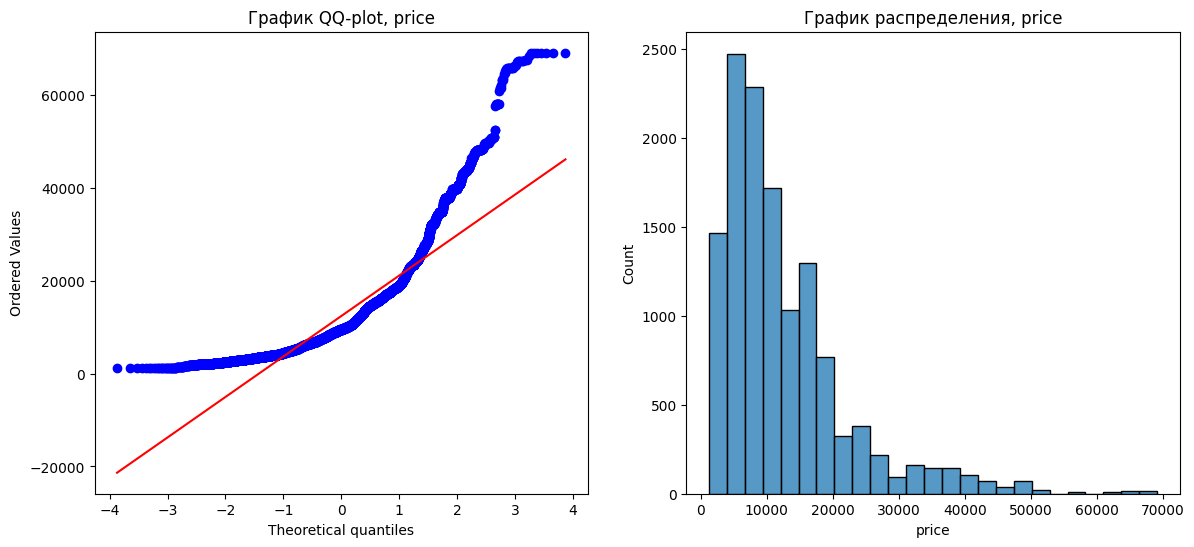

In [ ]:
result = app.invoke({
    'data': df
    , 'messages': 'Привет! Проверь, различаются ли цены по годам?'
}, {'recursion_limit': 1000})

In [ ]:
result.get('target')

'price'

In [ ]:
result.get('grouping_variable')

'dt'

In [ ]:
result.get('grouping_values')

['2025-07-08', '2025-07-14', '2025-07-15', '2025-07-22', '2025-07-29']

In [ ]:
result.get('messages')

[HumanMessage(content='Привет! Возьми промежутками пооо недели, и проверь, правда ли что цена меняется каждую неделю', additional_kwargs={}, response_metadata={}, id='89f47ab2-4398-4e9f-9d7b-3c6d544368c5')]

In [ ]:
result.get('grouping_variable_dtype')

'string'

In [ ]:
result.get('target_dtype')

'string'

In [ ]:
result.get('is_normal_target')

In [ ]:
result.get('summary')

'**Сводка исследования**\n\n**Введение**\n\nВ рамках данного исследования была проведена анализ данных о ценах и датах. Исследование включало в себя несколько этапов: изменение типов данных, построение логистической регрессии и анализ результатов.\n\n**Этап 1: Изменение типов данных**\n\nПервоначально типы данных были следующими:\n- `price`: int64\n- `dt`: object\n\nПосле изменения типы данных стали:\n- `price`: string[python]\n- `dt`: string[python]\n\n**Этап 2: Очистка данных**\n\nНа этом этапе не была проведена очистка выбросов.\n\n**Этап 3: Построение логистической регрессии**\n\nБыла построена логистическая регрессия с использованием модели MNLogit. Результаты регрессии представлены в таблице ниже:\n\n|  | coef | std err | z | P>|z| | [0.025 | 0.975 |\n| --- | --- | --- | --- | --- | --- | --- |\n| const | -25.6137 | 1.2e+04 | -0.002 | 0.998 | -2.36e+04 | 2.35e+04 |\n| 2025-07-14 | 18.7893 | 1.2e+04 | 0.002 | 0.999 | -2.35e+04 | 2.36e+04 |\n| 2025-07-15 | 19.4890 | 1.2e+04 | 0.002

In [ ]:
print(result.get('summary'))

**Сводка исследования**

**Введение**

В рамках данного исследования была проведена анализ данных о ценах и датах. Исследование включало в себя несколько этапов: изменение типов данных, построение логистической регрессии и анализ результатов.

**Этап 1: Изменение типов данных**

Первоначально типы данных были следующими:
- `price`: int64
- `dt`: object

После изменения типы данных стали:
- `price`: string[python]
- `dt`: string[python]

**Этап 2: Очистка данных**

На этом этапе не была проведена очистка выбросов.

**Этап 3: Построение логистической регрессии**

Была построена логистическая регрессия с использованием модели MNLogit. Результаты регрессии представлены в таблице ниже:

|  | coef | std err | z | P>|z| | [0.025 | 0.975 |
| --- | --- | --- | --- | --- | --- | --- |
| const | -25.6137 | 1.2e+04 | -0.002 | 0.998 | -2.36e+04 | 2.35e+04 |
| 2025-07-14 | 18.7893 | 1.2e+04 | 0.002 | 0.999 | -2.35e+04 | 2.36e+04 |
| 2025-07-15 | 19.4890 | 1.2e+04 | 0.002 | 0.999 | -2.35e+04 | 2.36e+

In [ ]:
def gen_png_graph(app_obj, name_photo: str = 'graph.png') -> None:
    with open(name_photo, 'wb') as f:
        f.write(app_obj.get_graph().draw_mermaid_png())

In [ ]:
gen_png_graph(app)